# Import 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_lowercase, ascii_uppercase
import matplotlib as mpl
import pandas as pd
from numba import jit, guvectorize, float32, float64, boolean


In [21]:
%reload_ext watermark
%watermark --iversions -v -m

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.27.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 4.19.0-26-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 56
Architecture: 64bit

__main__  : v02.7
xarray    : 2024.3.0
pandas    : 2.1.4
matplotlib: 3.9.2
numba     : 0.59.1
numpy     : 1.26.4



# Constants

In [3]:
xr.set_options(keep_attrs=True)
#infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update({"font.size": 22})

# Functions

In [4]:
def map_month(m):
    if m == 2:
        m_str = "DJF"
    elif m == 5:
        m_str = "MAM"
    elif m == 8:
        m_str = "JJA"
    elif m == 11:
        m_str = "SON"
    else:
        m_str = "NaN"

    return m_str


def map_time_str(time):
    year_arr = time.dt.year.values
    month_arr = time.dt.month.values

    month_str_ls = list(map(map_month, month_arr))
    func = lambda x, y: str(x) + "-" + y
    date_str = list(map(func, year_arr, month_str_ls))

    return date_str

@guvectorize(
    [
        (float64[:], float64[:], float64[:], boolean, float64[:]),
        (float32[:], float32[:], float32[:], boolean, float32[:]),
    ],
    "(n),(n),(m),()->(m)",
    nopython=True,
)
def _interp_1d_linear(phi, theta, target_theta_levels, mask_edges, output):
    # if last theta value is smaller than first, assume the profile is monotonically decreasing and flip
    if theta[-1] < theta[0]:
        theta = np.flip(theta)
        phi = np.flip(phi)

    output[:] = np.interp(target_theta_levels, theta, phi)

    if mask_edges:
        theta_max = np.nanmax(theta)
        theta_min = np.nanmin(theta)
        for i in range(len(target_theta_levels)):
            theta_lev = target_theta_levels[i]
            if (theta_lev < theta_min) or (theta_lev > theta_max):
                output[i] = np.nan


def interp_1d_linear(phi, theta, target_theta_levels, mask_edges=True):
    """
    Vectorized interpolation of scalar phi to isosurfaces of scalar theta
    along the final axis.
    Parameters
    ----------
    phi : array_like
        Array of shape (..., n), scalar field to be interpolated
    theta : array_like
        Array of shape (..., n), scalar field which defines the isosurfaces
    target_theta_levels : array_like
        Array of shape (m) specificying target isosurface levels
    mask_edges : bool, optional
        Determines how to handle theta values that exceed the bounds of
        target_theta_levels. If False, fill with nearest valid values. If
        True, fill with NaNs.
    Returns
    -------
    phi_interp : array
        Array of shape (..., m) of phi interpolated to theta isosurfaces.
    """
    return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


def linear_interpolation(
    phi, theta, target_theta_levels, phi_dim, theta_dim, target_dim, **kwargs):
    out = xr.apply_ufunc(
        interp_1d_linear,
        phi,
        theta,
        target_theta_levels,
        kwargs=kwargs,
        input_core_dims=[[phi_dim], [theta_dim], [target_dim]],
        output_core_dims=[[target_dim]],
        exclude_dims=set((phi_dim,)),
        dask="parallelized",
        output_dtypes=[np.float32],
    )
    out[target_dim] = target_theta_levels
    return out

# Open GloSSAC

In [5]:
ds_glo_ht = xr.open_dataset('HTHH_SOCOL_mass_GloSSAC_2022.nc', decode_times=False)
ds_glo_ht

<xarray.Dataset> Size: 968kB
Dimensions:               (altitude: 70, latitude: 36, time: 12,
                           solar_bands: 4, terrestrial_bands: 16)
Coordinates:
  * altitude              (altitude) float32 280B 5.0 5.5 6.0 ... 38.5 39.0 39.5
  * latitude              (latitude) float32 144B -87.5 -82.5 ... 82.5 87.5
  * time                  (time) float32 48B 1.0 2.0 3.0 4.0 ... 10.0 11.0 12.0
Dimensions without coordinates: solar_bands, terrestrial_bands
Data variables:
    wl1_sun               (solar_bands) float32 16B ...
    wl2_sun               (solar_bands) float32 16B ...
    wl1_earth             (terrestrial_bands) float32 64B ...
    wl2_earth             (terrestrial_bands) float32 64B ...
    pressure              (time, altitude, latitude) float32 121kB ...
    number_density        (time, altitude, latitude) float32 121kB ...
    surface_area_density  (time, altitude, latitude) float32 121kB ...
    volume_density        (time, altitude, latitude) float32 121kB ...
    effective_radius      (time, altitude, latitude) float32 121kB ...
    mode_radius           (time, altitude, latitude) float32 121kB ...
    mean_radius           (time, altitude, latitude) float32 121kB ...
    mixing_ratio          (time, altitude, latitude) float32 121kB ...
Attributes: (12/13)
    title:             Mass-related stratopheric aerosol properties, monthly ...
    Institution_id:    IACETH
    Institution:       Institute for Atmospheric and Climate Science, ETH Zur...
    activity_id:       HT-MOC
    Conventions:       CF-1.6
    data_structure:    grid
    ...                ...
    creation_date:     20240524
    source:            GloSSACv2.22, SAGE III
    source_id:         GloSSAC HT-MOC
    further_info_url:  ftp://iacftp.ethz.ch/pub_read/luo/CMIP6/data_descripti...
    contact:           Andrin Jörimann: andrin.joerimann@env.ethz.ch or Beipi...
    comment:           We take only the sulfuric acid aerosol into account. T...

In [12]:
ds_glo_bg = xr.open_dataset('BG_SOCOL_mass_GloSSAC_param.nc', decode_times=False)
ds_glo_bg

<xarray.Dataset> Size: 1MB
Dimensions:                       (altitude: 70, latitude: 36, time: 12,
                                   solar_bands: 14, terrestrial_bands: 16)
Coordinates:
  * altitude                      (altitude) float32 280B 5.0 5.5 ... 39.0 39.5
  * latitude                      (latitude) float32 144B -87.5 -82.5 ... 87.5
  * time                          (time) float32 48B 1.0 2.0 3.0 ... 11.0 12.0
Dimensions without coordinates: solar_bands, terrestrial_bands
Data variables: (12/13)
    wl1_sun                       (solar_bands) float32 56B ...
    wl2_sun                       (solar_bands) float32 56B ...
    wl1_earth                     (terrestrial_bands) float32 64B ...
    wl2_earth                     (terrestrial_bands) float32 64B ...
    pressure                      (time, altitude, latitude) float32 121kB ...
    number_density                (time, altitude, latitude) float32 121kB ...
    ...                            ...
    surface_area_density          (time, altitude, latitude) float32 121kB ...
    volume_density                (time, altitude, latitude) float32 121kB ...
    effective_radius              (time, altitude, latitude) float32 121kB ...
    mode_radius                   (time, altitude, latitude) float32 121kB ...
    mean_radius                   (time, altitude, latitude) float32 121kB ...
    mixing_ratio                  (time, altitude, latitude) float32 121kB ...
Attributes: (12/13)
    title:             Mass-related stratopheric aerosol properties, monthly ...
    Institution_id:    IACETH
    Institution:       Institute for Atmospheric and Climate Science, ETH Zur...
    activity_id:       HT-MOC
    Conventions:       CF-1.6
    data_structure:    grid
    ...                ...
    creation_date:     20240524
    source:            GloSSACv2.22, SAGE III
    source_id:         GloSSAC HT-MOC
    further_info_url:  ftp://iacftp.ethz.ch/pub_read/luo/CMIP6/data_descripti...
    contact:           Andrin Jörimann: andrin.joerimann@env.ethz.ch or Beipi...
    comment:           We take only the sulfuric acid aerosol into account. T...

In [13]:
plevc = ds.level.values
vert_c_name = 'altitude'
vet_new_name = 'level'
ds_glo_ht_press = linear_interpolation(ds_glo_ht[['surface_area_density']], 
                                  ds_glo_ht['pressure'], 
                                  plevc,
                                  vert_c_name, 
                                  vert_c_name, 
                                  vet_new_name)
ds_glo_bg_press = linear_interpolation(ds_glo_bg[['surface_area_density']], 
                                  ds_glo_bg['pressure'], 
                                  plevc,
                                  vert_c_name, 
                                  vert_c_name, 
                                  vet_new_name)

In [14]:
sad_glo_anom = ds_glo_ht_press['surface_area_density']-ds_glo_bg_press['surface_area_density']
sad_glo_anom['time'] = pd.date_range('2022-01', periods = 12, freq = 'M')
#sad_glo_anom['altitude'] = 1013.25*np.exp(-arr_glo['altitude']/7)
arr_glo = sad_glo_anom.resample(time=how_rt).mean().squeeze()
arr_glo["time"] = map_time_str(arr_glo.time)
arr_glo

<xarray.DataArray 'surface_area_density' (time: 5, latitude: 36, level: 31)> Size: 45kB
array([[[2.45756776, 2.96306748, 2.09713871, ...,        nan,
                nan,        nan],
        [2.45756776, 2.96306748, 2.09713871, ...,        nan,
                nan,        nan],
        [2.45756776, 2.96306748, 2.09713871, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[1.35757695, 1.25033009, 0.7796358 , ...,        nan,
                nan,        nan],
        [1.35757695, 1.25033009, 0.7796358 , ...,        nan,
                nan,        nan],
        [1.35757695, 1.25033009, 0.7796358 , ...,        nan,
                nan,        nan],
...
        [2.76268556,        nan, 2.00979061, ...,        nan,
                nan,        nan],
        [2.76268556,        nan, 2.00979061, ...,        nan,
                nan,        nan],
        [2.76268556,        nan, 2.00979061, ...,        nan,
                nan,        nan]],

       [[1.87919539, 2.50072119, 2.20681722, ...,        nan,
                nan,        nan],
        [1.87919539, 2.50072119, 2.20681722, ...,        nan,
                nan,        nan],
        [1.87919539, 2.50072119, 2.20681722, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * latitude  (latitude) float32 144B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * level     (level) float32 124B 316.2 261.0 215.4 177.8 ... 1.468 1.212 1.0
  * time      (time) <U8 160B '2022-DJF' '2022-MAM' ... '2022-SON' '2023-DJF'
Attributes:
    units:    um^2/cm^3

In [15]:
da_zeros = (arr_glo[:-1]*np.nan) # xr.zeros_like
da_zeros['time'] = ['2023-MAM','2023-JJA', '2023-SON', '2024-DJF']
arr_glo_all = xr.concat([arr_glo, da_zeros], dim = 'time')
arr_glo_all.attrs['units'] = r'$\mathrm{\mu m^2/cm^3}$'
arr_glo_all.name = 'SAD'

# SWOOSH v2.7

In [9]:
inpath = '/sto0/data/Intermediate/Hunga_Tonga_byAles/'
dataset = 'swoosh'
version='v02.7'
infile = f'{inpath}{dataset}/swoosh-{version}-198401-202312-latpress-2.5deg-L31.nc'

In [10]:
ds = xr.open_dataset(infile)
ds

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'aceh2on' has non-conforming 'missing_value' nan defined, dropping 'missing_value' entirely.
  var = coder.decode(var, name=name)
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'aceh2oneq' has non-conforming 'missing_value' nan defined, dropping 'missing_value' entirely.
  var = coder.decode(var, name=name)
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'acen2on' has non-conforming 'missing_value' nan defined, dropping 'missing_value' entirely.
  var = coder.decode(var, name=name)
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'acen2oneq' has non-conforming 'missing_value' nan defined, dropping 'missing_value' entirely.
  var = coder

<xarray.Dataset> Size: 1GB
Dimensions:                     (lat: 72, level: 31, time: 480, latbound: 73)
Coordinates:
  * lat                         (lat) float32 288B -88.75 -86.25 ... 86.25 88.75
  * level                       (level) float32 124B 316.2 261.0 ... 1.212 1.0
  * time                        (time) datetime64[ns] 4kB 1984-01-16T12:00:00...
  * latbound                    (latbound) float32 292B -90.0 ... 9.969e+36
Data variables: (12/360)
    month                       (time) int16 960B ...
    year                        (time) int16 960B ...
    yrtime                      (time) float32 2kB ...
    jultime                     (time) float64 4kB ...
    aceanomh2oq                 (time, level, lat) float32 4MB ...
    aceanomo3q                  (time, level, lat) float32 4MB ...
    ...                          ...
    ompso3meandiff              (level) float32 124B ...
    ompso3meandiffvslat         (level, lat) float32 9kB ...
    ompso3offseterrvslat        (level, lat) float32 9kB ...
    uarsmlso3meandiff           (level) float32 124B ...
    uarsmlso3meandiffvslat      (level, lat) float32 9kB ...
    uarsmlso3offseterrvslat     (level, lat) float32 9kB ...
Attributes: (12/14)
    title:              SWOOSH data set
    version:            02.7
    created:            Fri Feb  2 22:05:01 2024
    SWOOSHVERSION:      02.7
    UARSMLSH2OVERSION:  6
    OMPSVERSION:        2.6
    ...                 ...
    MLSVERSION:         5.0
    SAGE2VERSION:       7.0
    UARSMLSO3VERSION:   5
    HALOEVERSION:       19
    ACEVERSION:         5.2
    Conventions:        CF-1.4

## visualization

### Seasonally

In [16]:
sel_dict = dict(time = slice('2021-12',None), level = slice(300,None))
sel_var_ls = ['combinedanomh2oq', 'combinedanomo3q','tropp','combinedanomfillo3q','combinedanomfillanomo3q']
ds_sel = ds[sel_var_ls].sel(**sel_dict)

#### H2O

In [17]:
#time_slice = slice("2022-01", "2023-12", 2)
#time_slice = slice("2022-01", "2024-12-31")
how_rt = "Q-NOV"  # "1Q"

#sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "combinedanomh2oq"


arr = ds_sel.resample(time=how_rt).mean().squeeze()
arr["time"] = map_time_str(arr.time)
arr


<xarray.Dataset> Size: 314kB
Dimensions:                  (time: 9, level: 30, lat: 72)
Coordinates:
  * lat                      (lat) float32 288B -88.75 -86.25 ... 86.25 88.75
  * level                    (level) float32 120B 261.0 215.4 ... 1.212 1.0
  * time                     (time) <U8 288B '2022-DJF' ... '2024-DJF'
Data variables:
    combinedanomh2oq         (time, level, lat) float32 78kB nan nan ... nan nan
    combinedanomo3q          (time, level, lat) float32 78kB nan nan ... nan nan
    tropp                    (time, lat) float32 3kB 281.7 280.8 ... 265.5 264.6
    combinedanomfillo3q      (time, level, lat) float32 78kB nan nan ... nan nan
    combinedanomfillanomo3q  (time, level, lat) float32 78kB -0.01973 ... -0....
Attributes: (12/14)
    title:              SWOOSH data set
    version:            02.7
    created:            Fri Feb  2 22:05:01 2024
    SWOOSHVERSION:      02.7
    UARSMLSH2OVERSION:  6
    OMPSVERSION:        2.6
    ...                 ...
    MLSVERSION:         5.0
    SAGE2VERSION:       7.0
    UARSMLSO3VERSION:   5
    HALOEVERSION:       19
    ACEVERSION:         5.2
    Conventions:        CF-1.4

/tmp/ipykernel_17317/670595697.py:31: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
/tmp/ipykernel_17317/670595697.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(lat, arr['tropp'].sel(**sel_dict).values, "k--", lw=3, color="purple")


combinedanomh2oq+SAD_time-evolution-SWOOSHv02.7+GloSSAC_globally.pdf


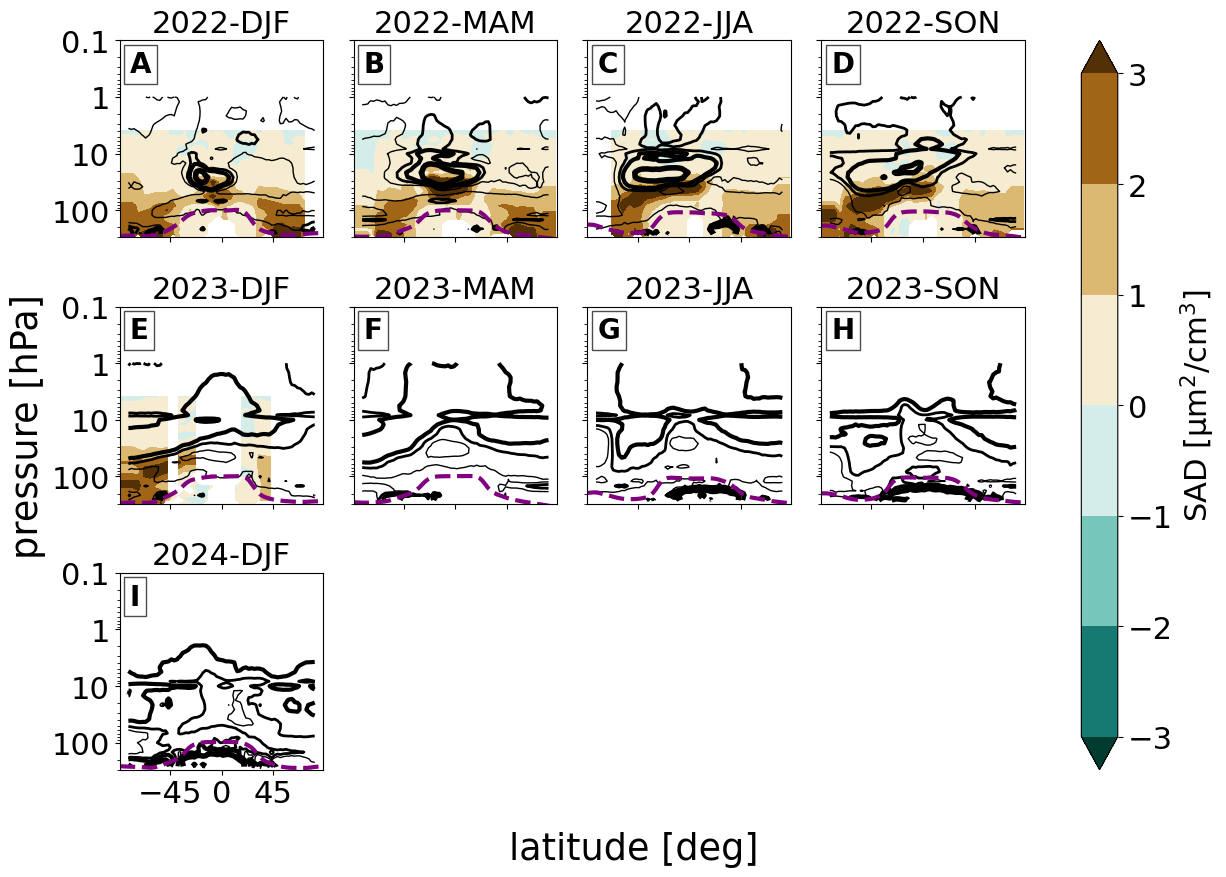

In [22]:
levs = [5, 10, 20, 50]
nl = len(levs)
sel_var = "combinedanomh2oq"
sel_var2 = 'SAD'

p = arr[sel_var].plot.contour(
    x="lat", col="time", yincrease=False, col_wrap=4, robust=True, 
    colors=("k"),
    add_colorbar=False,
    levels=[0.1, 0.5, 1, 3],
    linewidths=np.linspace(1, 4, 4),
)

p.data = arr_glo_all
kwargs = dict(
    yincrease=False, robust=True, cmap="BrBG_r", vmax = 3, extend = 'both'
)
p.map_dataarray(xr.plot.contourf, "latitude", "level", **kwargs)

p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]")

plt.ylim(300, 0.1)
plt.yscale("log")

lat = arr.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, +45])
    #print(sel_dict)
    try:
        ax.plot(lat, arr['tropp'].sel(**sel_dict).values, "k--", lw=3, color="purple")
    except:
        pass

outfile = f"{sel_var}+{sel_var2}_time-evolution-SWOOSH{version}+GloSSAC_globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")